In [66]:
import time
import  torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as td
import torch.nn.functional as F

定义变量

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
num_works = 8
batch_size = 128
input_dim=100
epochs = 1
print("run on ",device.type)

run on  cuda


In [68]:
from typing import Iterable
# loading data
def loading_minist_data(batch_siz:int, works:int)->(Iterable,Iterable):

    train_set = torchvision.datasets.MNIST(root="./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
    test_set = torchvision.datasets.MNIST(root="./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)
    return td.DataLoader(dataset=train_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True), td.DataLoader(dataset=test_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True)


In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(

                        torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                        torch.nn.ReLU(),
                        torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                        torch.nn.ReLU(),
                        torch.nn.MaxPool2d(stride=2,kernel_size=2),
                        nn.Flatten(),
                        torch.nn.Linear(14*14*128,1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.5),
                        torch.nn.Linear(1024, 10)
        #     nn.Flatten(),
        #     nn.Linear(28*28,128),
        #     nn.ReLU(),
        #     nn.Linear(128,10)
        ).to(device)
        self.cnt=0
        self.loss_metric=[]
        self.loss_func = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters())
        pass
    def forward(self,inputs):
        for i in self.model:
            # print(inputs.shape)
            inputs = i(inputs)
        return inputs
        # return self.model(inputs)
    def train(self,inputs,targets):
        out = self.forward(inputs)

        loss = self.loss_func(out,targets)
        self.cnt+=1
        self.loss_metric.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass

class Generator(nn.Module):
    def __init__(self,in_dim:int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        ).to(device)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        # counter and accumulator for progress
        self.cnt = 0
        self.loss_metric = []


    def forward(self,inputs):
        return self.model(inputs).view(batch_size,28,28)
    def train(self,D:Discriminator,inputs,targets):
        gen_out = self.forward(inputs)
        # print(gen_out.shape)
        d_out = D.forward(gen_out)

        loss  = D.loss_func(d_out,targets)
                # zero gradients, perform a backward pass, update weights
        self.cnt+=1
        self.loss_metric.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

def generate_random_seed(size):
    random_data = torch.randn(size*batch_size).view(batch_size,size)
    return random_data.to(device)


In [70]:
# D = Discriminator()
# t = torch.randn(size=(1,1,28,28)).to(device)
# D.forward(t)

In [71]:
%%time
loss_metric =[]
train_acc_metric=[]
test_acc_metric =[]
def add_metric(x,y,z):
    loss_metric.append(x)
    train_acc_metric.append(y)
    test_acc_metric.append(z)
D = Discriminator()
train_iter ,test_iter = loading_minist_data(batch_size,4)
epochs = 10
cost = nn.CrossEntropyLoss()
for k in range(epochs):
    print("start epoch {} of {} ".format(k+1,epochs) )
    running_loss = 0
    running_acc = 0
    testing_acc = 0
    time_start = time.time()
    for it,y in train_iter:
        it = it.to(device)
        y = y.to(device)
        out = D.forward(it)
        loss = cost(out,y)
        D.optimizer.zero_grad()
        loss.backward()
        D.optimizer.step()
        running_loss +=loss.detach().item()
        _ ,pred =  torch.max(out,1)
        running_acc +=  torch.sum(pred==y.data)
    for tes,y in test_iter:
        tes = tes.to(device)
        y = y.to(device)
        outputs  = D.model(tes)
        _ ,pred =  torch.max(outputs,1)
        testing_acc += torch.sum(pred==y.data)
    print(running_acc)
    print(testing_acc)
    len1 = len(train_iter)*batch_size
    len2 = len(test_iter)*batch_size
    t_l,t_a,r_a = running_loss/len1,100*running_acc/len1,100*testing_acc/len2
    # t_a = t_a.to(device_cpu)
    # r_a = r_a.to(device_cpu)
    add_metric(t_l,t_a.to(device_cpu),r_a.to(device_cpu))
    # print(running_loss * 100 / len(train_iter)train_iter)
    print("spend time{},train_loss : {}, training_acc {} , testing_acc {}".format(time.time()-time_start,
                                                                                t_l,t_a,r_a
                                                                                  ))
# output = G.forward(generate_random_seed(input_dim))
# img = output.detach().numpy().reshape(28,28)
# plt.imshow(output.cpu().detach().numpy()[0], interpolation='none', cmap='Blues')

start epoch 1 of 10 
tensor(56822, device='cuda:0')
tensor(9812, device='cuda:0')
spend time34.353357553482056,train_loss : 0.0012975498606014547, training_acc 94.8551025390625 , testing_acc 98.2772445678711
start epoch 2 of 10 
tensor(58986, device='cuda:0')
tensor(9809, device='cuda:0')
spend time34.224644899368286,train_loss : 0.00038040180817962467, training_acc 98.4675521850586 , testing_acc 98.24720001220703
start epoch 3 of 10 
tensor(59279, device='cuda:0')
tensor(9845, device='cuda:0')
spend time34.48666548728943,train_loss : 0.00025721571217055054, training_acc 98.95667266845703 , testing_acc 98.60777282714844
start epoch 4 of 10 
tensor(59460, device='cuda:0')
tensor(9855, device='cuda:0')
spend time34.907498836517334,train_loss : 0.00017955032365274453, training_acc 99.25881958007812 , testing_acc 98.70793151855469
start epoch 5 of 10 
tensor(59554, device='cuda:0')
tensor(9857, device='cuda:0')
spend time35.2940878868103,train_loss : 0.0001403366707759971, training_acc 99.

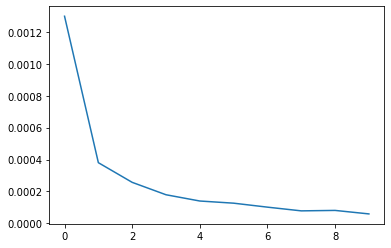

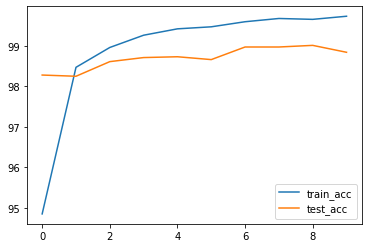

In [74]:
from matplotlib.pyplot import  MultipleLocator
x = [i for i in range(epochs)]
plt.figure(1)
plt.plot(x,loss_metric,label="loss")
plt.figure(2)
plt.plot(x,train_acc_metric,label="train_acc")
plt.plot(x,test_acc_metric,label="test_acc")
# ax = plt.gca()
# ax.yaxis.set_major_locator(MultipleLocator(1))
plt.legend()
plt.show()

In [73]:
# x = torch.randn(size=(64,10)
#             )
# y = torch.randint(0,10,size=(64,1))
# _,pred = torch.max(x,1)
# # torch.sum(pred==y)
